In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib import gridspec
from datetime import datetime
from scipy import interpolate
from scipy import integrate
import scipy.stats
import numpy.ma as ma
import numpy as np
from matplotlib import gridspec
import warnings # Silence the warnings from SHARPpy
warnings.filterwarnings("ignore")
from scipy.stats import kde
import trackpy as tp
import glob
import os
import rasterio
import seaborn as sns
import pims
dem_files = sorted(glob.glob('/data/accp/a/snesbitt/relampago/srtm/*.tif'))
ds_list = []
for file in dem_files:
   ds_list.append(xr.open_rasterio(file).isel(band=0))


In [2]:
gpd_jan25 = pd.read_csv('/data/keeling/a/melinda3/accp/tracking_ots/ot_trajectories_trackpy_v2.csv')
gpd_jan25
 

Unnamed: 0.1  Unnamed: 0                           time        lat  \
0              8661           0  2018-11-05 00:00:57.000000512 -33.508930   
1              8662           1  2018-11-05 00:00:57.000000512 -34.348217   
2              8663           2  2018-11-05 00:00:57.000000512 -34.330357   
3              8664           3  2018-11-05 00:00:57.000000512 -34.366070   
4              8665           4  2018-11-05 00:00:57.000000512 -34.294643   
...             ...         ...                            ...        ...   
59930         85648        1030  2019-01-30 21:44:52.000000000 -30.437498   
59931         85649        1031  2019-01-30 21:45:52.000000000 -30.437498   
59932         85650        1032  2019-01-30 21:46:52.000000000 -30.437498   
59933         85651        1033  2019-01-30 21:54:52.000000000 -30.437498   
59934         85652        1034  2019-01-30 21:55:52.000000000 -30.437498   

             lon   lat_corr   lon_corr  otid      mintb  tropopause_height  \
0     -64.508934 -33.388930 -64.548935  15.0  204.25000          15.821001   
1     -65.687500 -34.223217 -65.724500  33.0  202.34000          14.890000   
2     -65.562500 -34.205357 -65.599500  37.0  201.95000          14.893001   
3     -65.687500 -34.242070 -65.724500  38.0  202.43000          14.875001   
4     -65.633934 -34.189500 -65.848500  39.0  203.37000          14.945001   
...          ...        ...        ...   ...        ...                ...   
59930 -60.526787 -30.327497 -60.581787  14.0  197.34999          16.356000   
59931 -60.508926 -30.327497 -60.563927  13.0  197.15000          16.356000   
59932 -60.508926 -30.327497 -60.563927  13.0  197.29000          16.356000   
59933 -60.455357 -30.328499 -60.510357  12.0  197.86000          16.356000   
59934 -60.455357 -30.328499 -60.510357  11.0  197.86000          16.356000   

       ...  states  label              x              y        date  hour  \
0      ...       0      0 -232607.654663 -170514.189762  2018-11-05     0   
1      ...       0      0 -338503.822085 -266969.943218  2018-11-05     0   
2      ...       0      0 -327104.894238 -264593.656015  2018-11-05     0   
3      ...       0      0 -338432.784285 -268954.245761  2018-11-05     0   
4      ...       0      0 -333799.671474 -260846.004865  2018-11-05     0   
...    ...     ...    ...            ...            ...         ...   ...   
59930  ...       0      0  141248.527197  172791.285481  2019-01-30    21   
59931  ...       0      0  142960.828342  172768.065453  2019-01-30    21   
59932  ...       0      0  142960.828342  172768.065453  2019-01-30    21   
59933  ...       0      0  148096.351698  172696.745382  2019-01-30    21   
59934  ...       0      0  148096.351698  172696.745382  2019-01-30    21   

      particle     cell  count Count_Column  
0            0      1.0    1.0          3.0  
1            1      NaN    NaN          NaN  
2            2      3.0    1.0          5.0  
3            3      4.0    1.0          2.0  
4            4      5.0    1.0          6.0  
...        ...      ...    ...          ...  
59930    23351  23352.0    1.0          6.0  
59931    23351  23352.0    1.0          6.0  
59932    23351  23352.0    1.0          6.0  
59933    23351  23352.0    1.0          6.0  
59934    23351  23352.0    1.0          6.0  

[59935 rows x 59 columns]

In [3]:
times = gpd_jan25.time
hours = []
months = []
for time in times:
   test = datetime.strptime(time[0:19], '%Y-%m-%d %H:%M:%S')
   hours.append(test.hour)
   months.append(test.month)

In [4]:
times_dt = pd.to_datetime(times)
st_times = times_dt.dt.strftime('%Y-%m-%d %H:%M:%S')
gpd_jan25['time_conv'] = st_times

In [5]:
gpd_jan25['ot_depth'] = gpd_jan25['cloudtop_height'] - gpd_jan25['trop_height']
#gpd_jan25['count'] = gpd_jan25['cell'].transform('nunique')
#trajectories_filtered['size'] = trajectories_filtered.groupby(['cell']).transform(np.size)
gpd_jan25['duration'] = gpd_jan25['cell'].map(gpd_jan25['cell'].value_counts())
gpd_jan25['hours'] = hours
gpd_jan25['month'] = months
#gpd_jan25 = gpd_jan25.set_index('time')

In [6]:
gpd_jan25 = gpd_jan25[gpd_jan25.area_polygon > 4 ]
gpd_jan25 = gpd_jan25[gpd_jan25.lapse_rate > -9999]
gpd_jan25 = gpd_jan25[gpd_jan25.n2 > -9999]
gpd_jan25 = gpd_jan25[gpd_jan25.ot_depth < 7]
gpd_jan25 = gpd_jan25[gpd_jan25.ot_depth > 0]

In [7]:
grouped_ots = gpd_jan25.groupby('cell')

In [8]:
og_map = plt.cm.get_cmap('magma')
rev_map = og_map.reversed()
 

In [9]:
jan25_lapserate = grouped_ots.median('lapse_rate').lapse_rate
jan25_n2calc = grouped_ots.median('n2').n2
ota_25jan = grouped_ots.median('area_polygon').area_polygon
otd_25jan = grouped_ots.median('ot_depth').ot_depth
w_max = grouped_ots.median('w').w
mucape = grouped_ots.median('mucape').mucape
duration = grouped_ots.duration.nth(0)
filt_dict = {'ota_25jan':ota_25jan, 'otd_25jan':otd_25jan, 'jan25_lapserate':jan25_lapserate, 'jan25_n2calc':jan25_n2calc,
              'w_max':w_max, 'mucape':mucape}

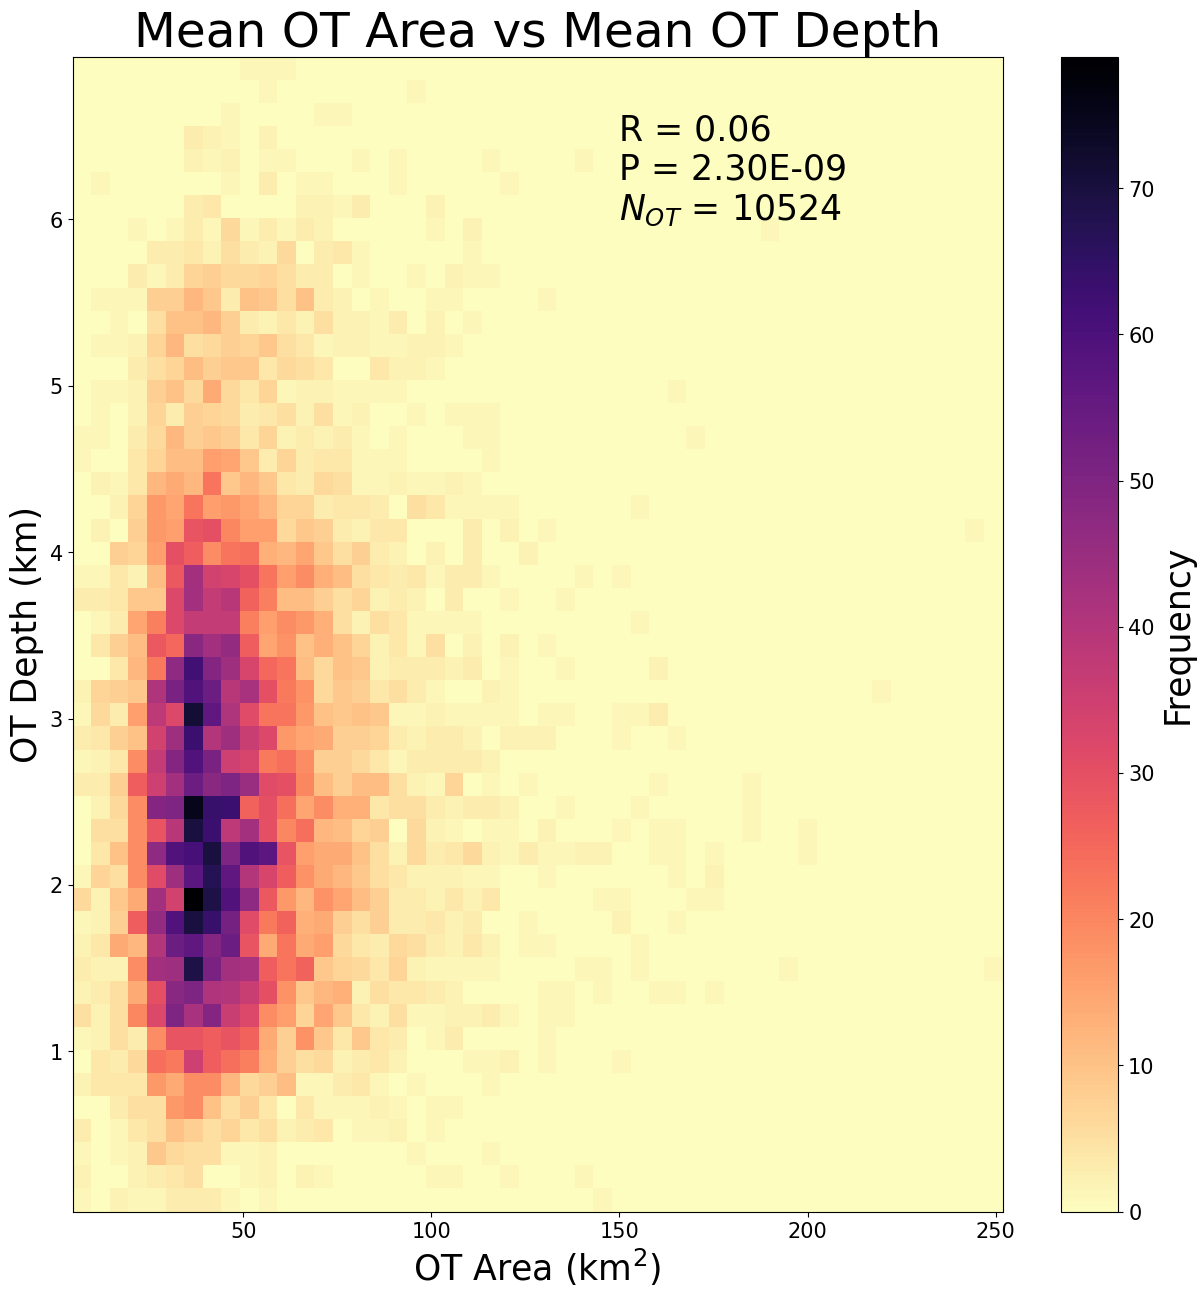

In [10]:
#Plot a scatter plot of the predicted vs actual top of the OT
fig, ax = plt.subplots(1,1,figsize=(15, 15))
otd_r_model = scipy.stats.linregress(ota_25jan, otd_25jan)
x2 = np.linspace(min(ota_25jan), max(ota_25jan),100)
r_otd = otd_r_model.rvalue
p_otd = otd_r_model.pvalue
y3 = otd_r_model.intercept + x2*otd_r_model.slope
samples = len(ota_25jan)
c,x,y, im1 = plt.hist2d(ota_25jan, otd_25jan, bins = (50,50), cmap = rev_map)
plt.text(150, 6, 'R = %0.2f\n'%r_otd + 'P = %0.2E\n'%p_otd + '$N_{OT}$ = %0.0f'%samples, fontsize = 25, color = 'black')
#plt.plot(x2, y3, "-k")
plt.title('Mean OT Area vs Mean OT Depth', fontsize = 35)
plt.xlabel('OT Area (km$^{2}$)', fontsize= 25)
plt.ylabel('OT Depth (km)', fontsize = 25)
#plt.legend(loc='best', fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
cbar = plt.colorbar()
cbar.set_label('Frequency', fontsize = 25)
cbar.ax.tick_params(labelsize = 15)


Text(0.5, 0.98, 'Median Statistics')

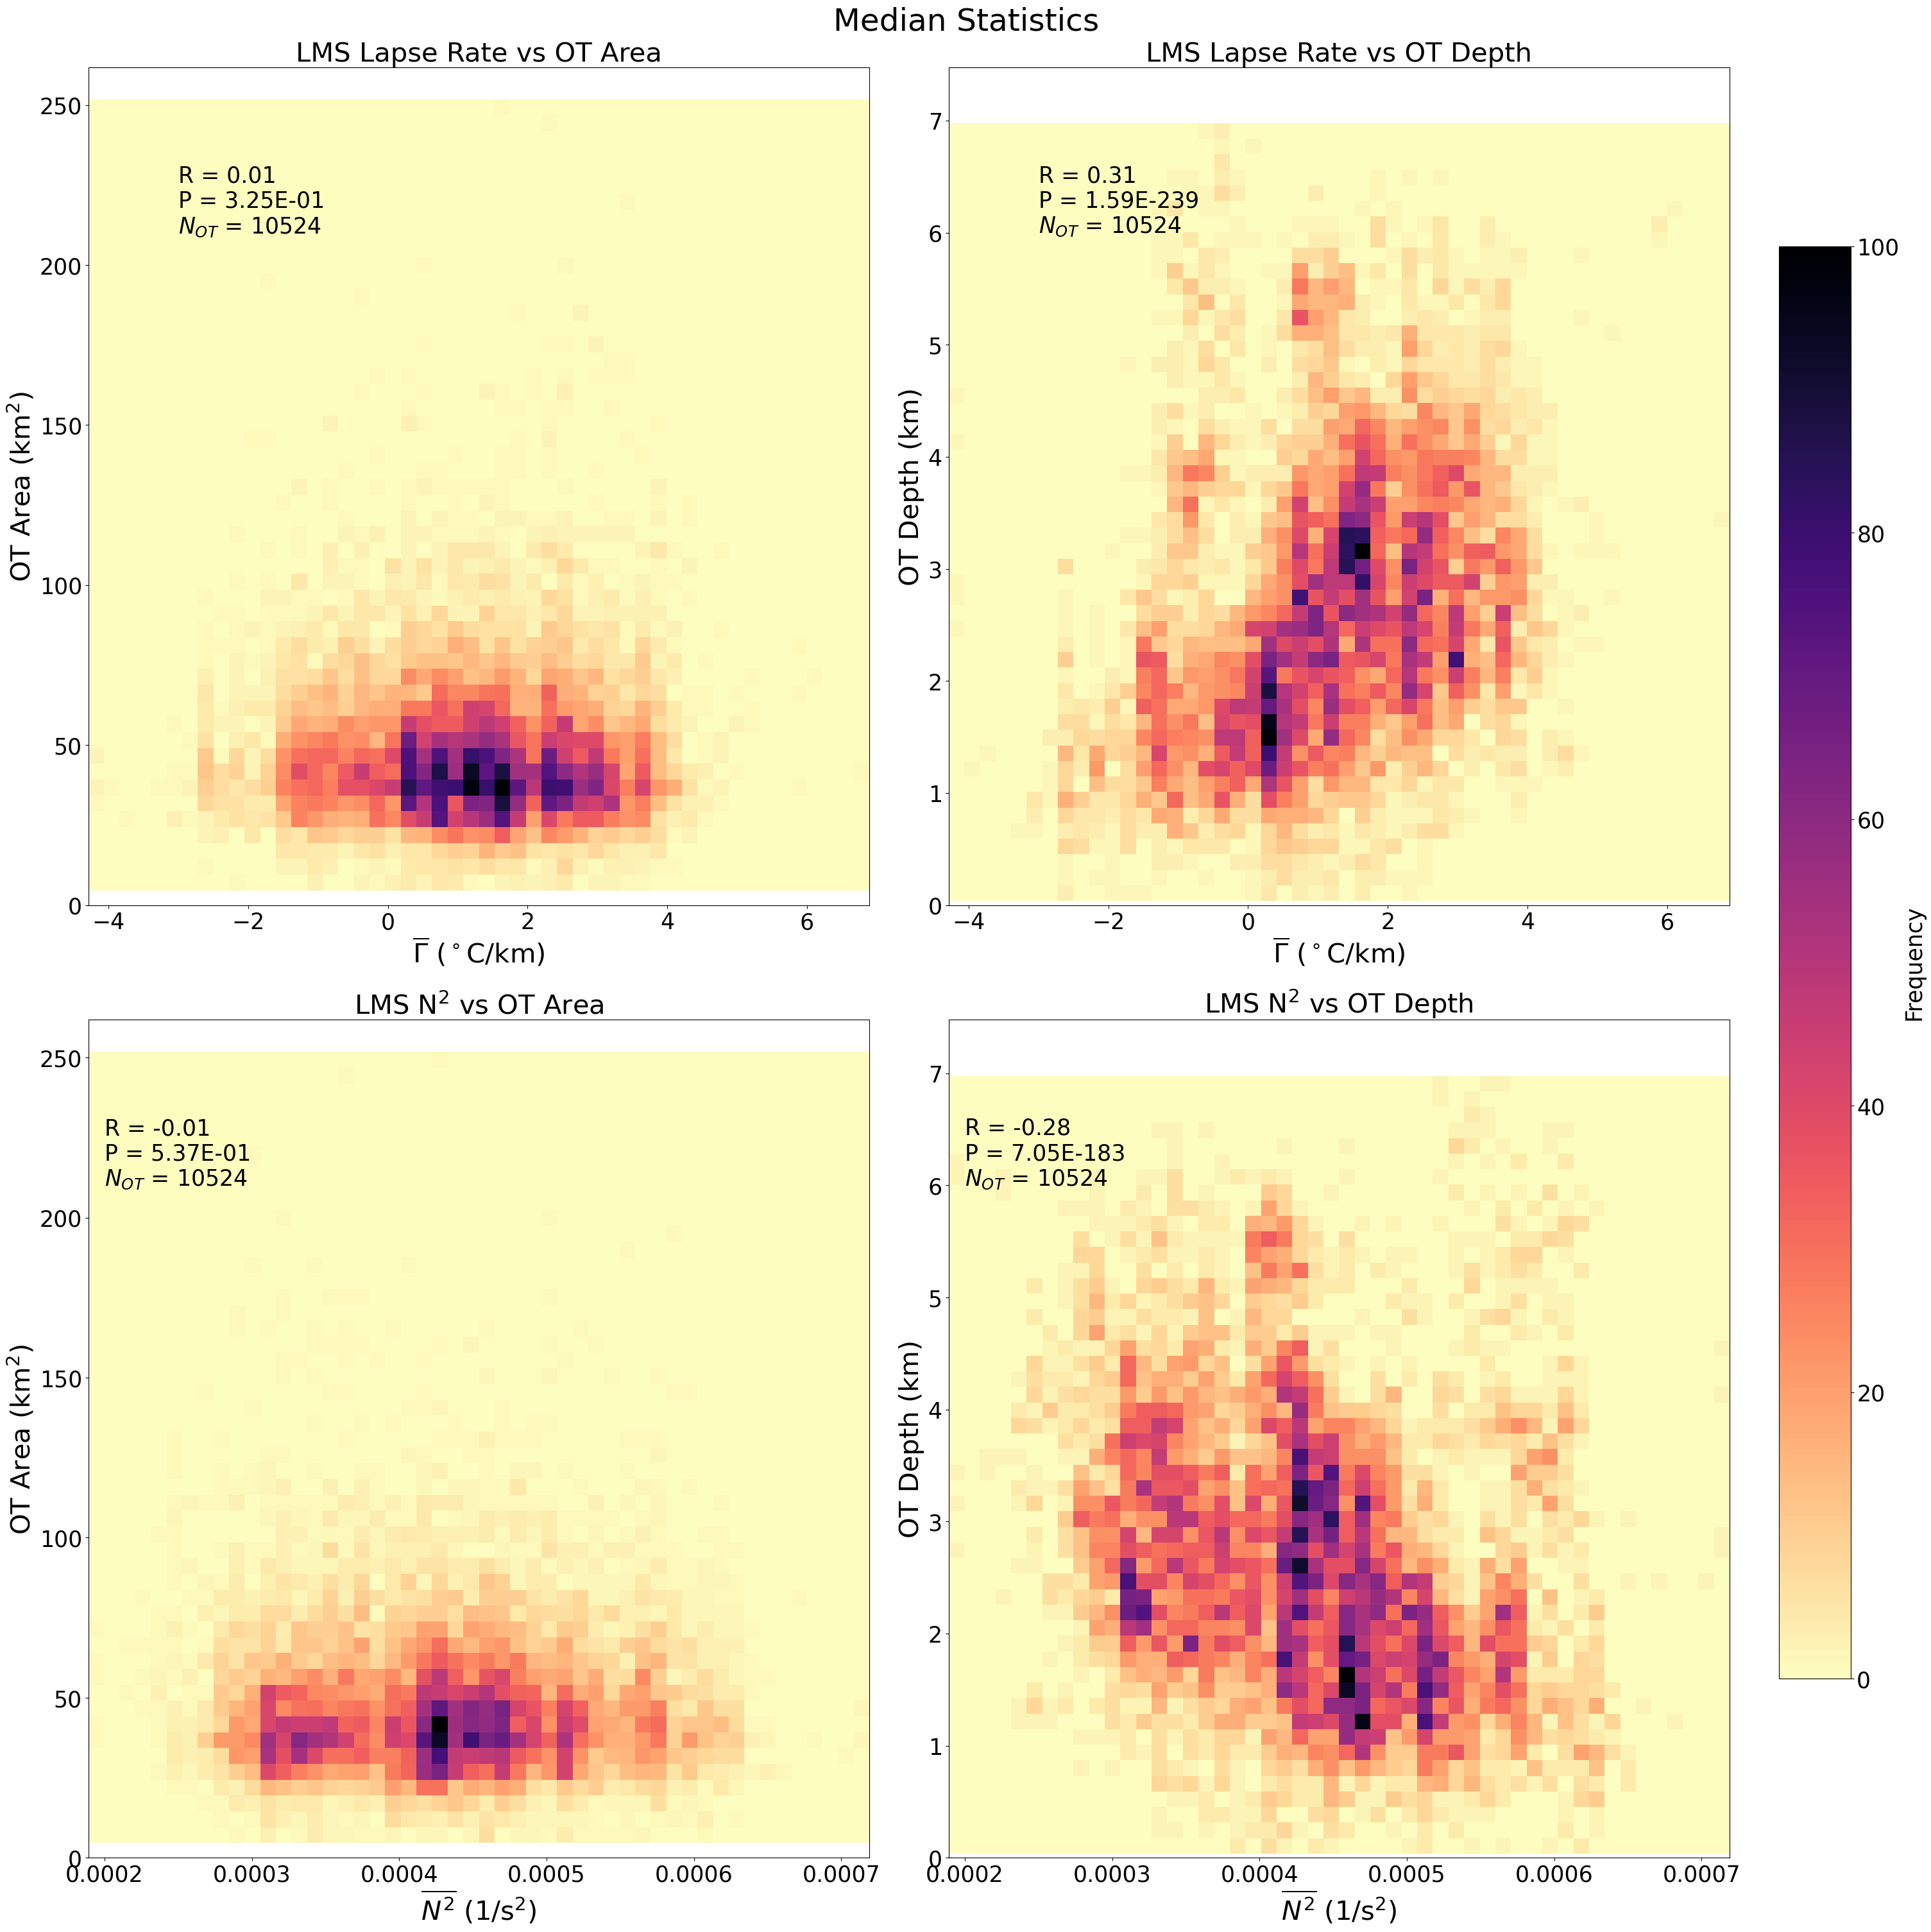

In [11]:
fig1, axes = plt.subplots(2,2,figsize=(30,30), constrained_layout=True)
samples = len(ota_25jan)
ota_r_model = scipy.stats.linregress(jan25_lapserate, ota_25jan)
r_ota = ota_r_model.rvalue
p_ota = ota_r_model.pvalue 
c,x,y, im1 = axes[0,0].hist2d(jan25_lapserate, ota_25jan, bins = (50,50), cmap = rev_map)
axes[0,0].text(-3, 210, 'R = %0.2f\n'%r_ota + 'P = %0.2E\n'%p_ota + '$N_{OT}$ = %0.0f'%samples, fontsize = 25, color = 'black')
#axes[0,0].plot(x5, y5, '-k')
axes[0,0].set_title('LMS Lapse Rate vs OT Area', fontsize = 30)
axes[0,0].set_xlabel('$\overline{\Gamma}$ ($^\circ$C/km)', fontsize = 30)
axes[0,0].set_ylabel('OT Area (km$^{2}$)', fontsize = 30)
axes[0,0].set_ylim(0, max(ota_25jan)+10)
#axes[0,0].legend( loc = 'best', fontsize = 10)
axes[0,0].tick_params(axis='x', labelsize=25)
axes[0,0].tick_params(axis='y', labelsize=25)
otd_r_model2 = scipy.stats.linregress(jan25_lapserate, otd_25jan)
r_otd2 = otd_r_model2.rvalue
p_otd2 = otd_r_model2.pvalue
#print([r_otd, p_otd])
axes[0,1].hist2d(jan25_lapserate, otd_25jan, bins=(50,50), cmap = rev_map)
axes[0,1].text(-3, 6, 'R = %0.2f\n'%r_otd2 + 'P = %0.2E\n'%p_otd2 + '$N_{OT}$ = %0.0f'%samples, fontsize = 25, color = 'black')
axes[0,1].set_title('LMS Lapse Rate vs OT Depth', fontsize = 30)
#axes[0,1].plot(x5, y6, '-k')
axes[0,1].set_xlabel('$\overline{\Gamma}$ ($^\circ$C/km)', fontsize = 30)
axes[0,1].set_ylabel('OT Depth (km)', fontsize = 30)
axes[0,1].set_ylim(0, max(otd_25jan)+0.5)
axes[0,1].tick_params(axis='x', labelsize=25)
axes[0,1].tick_params(axis='y', labelsize=25)


ota_r_model3 = scipy.stats.linregress(jan25_n2calc, ota_25jan)
r_ota3 = ota_r_model3.rvalue
p_ota3 = ota_r_model3.pvalue
axes[1,0].hist2d(jan25_n2calc, ota_25jan, bins=(50,50), cmap=rev_map)

axes[1,0].text(0.0002, 210, 'R = %0.2f\n'%r_ota3 + 'P = %0.2E\n'%p_ota3 + '$N_{OT}$ = %0.0f'%samples, fontsize = 25, color = 'black')
#axes[1,0].plot(x,y, '-k')
axes[1,0].set_title('LMS N$^{2}$ vs OT Area', fontsize = 30)
axes[1,0].set_xlabel('$\overline{N^{2}}$ (1/s$^{2}$)', fontsize = 30)
axes[1,0].set_ylabel('OT Area (km$^{2}$)', fontsize = 30)
axes[1,0].set_ylim(0, max(ota_25jan)+10)
#axes[1,0].legend( loc = 'best', fontsize = 10)
axes[1,0].tick_params(axis='x', labelsize=25)
axes[1,0].tick_params(axis='y', labelsize=25)
otd_r_model4 = scipy.stats.linregress(jan25_n2calc, otd_25jan)
r_otd4 = otd_r_model4.rvalue
p_otd4 = otd_r_model4.pvalue
axes[1,1].hist2d(jan25_n2calc, otd_25jan, bins=(50,50), cmap = rev_map)
axes[1,1].text(0.0002, 6, 'R = %0.2f\n'%r_otd4 + 'P = %0.2E\n'%p_otd4 + '$N_{OT}$ = %0.0f'%samples, fontsize = 25, color = 'black')
axes[1,1].set_title('LMS N$^{2}$ vs OT Depth', fontsize = 30)
#axes[1,1].plot(x,y7, '-k')
#axes[1,1].set_xtick(fontsize = 12, angle = 45)
axes[1,1].set_xlabel('$\overline{N^{2}}$ (1/s$^{2}$)', fontsize = 30)
axes[1,1].set_ylabel('OT Depth (km)', fontsize = 30)
axes[1,1].set_ylim(0, max(otd_25jan)+0.5)
#axes[1,1].legend(loc = 'best', fontsize = 20)
axes[1,1].tick_params(axis='x', labelsize=25)
axes[1,1].tick_params(axis='y', labelsize=25)
cbar = fig1.colorbar(im1, ax=axes[:, 1], shrink=0.8)
cbar.set_label('Frequency', fontsize = 25)
cbar.ax.tick_params(labelsize = 25)
plt.suptitle('Median Statistics', fontsize = 35)

Text(0.5, 0.98, 'Mean Statistics')

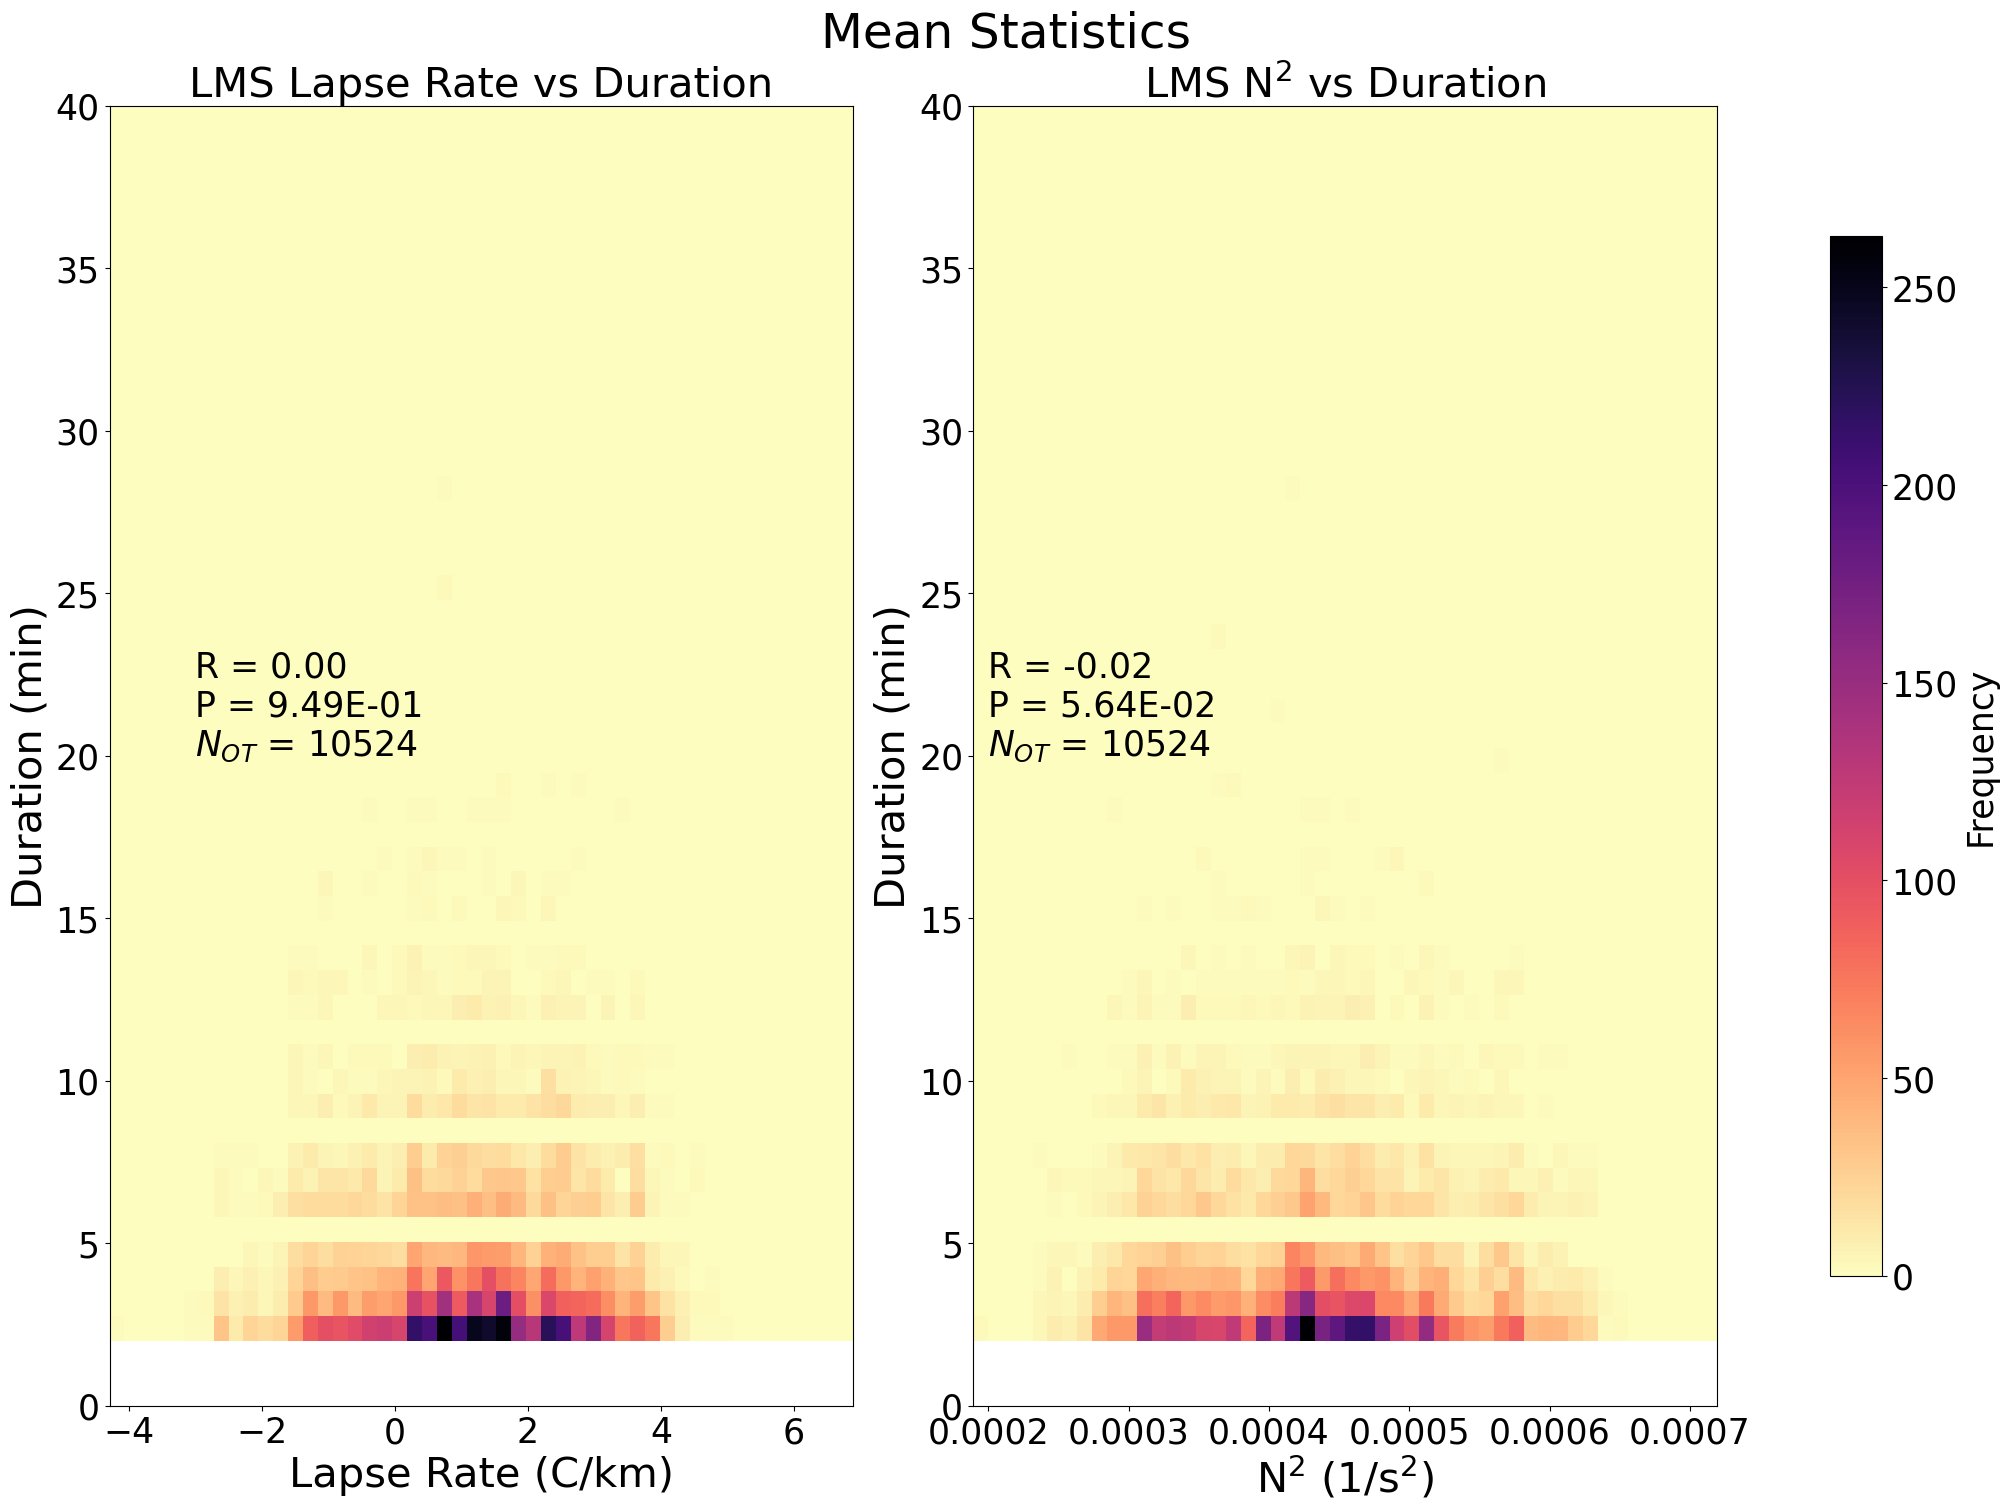

In [12]:
fig1, axes = plt.subplots(1,2,figsize=(20,15), constrained_layout=True)
samples = len(ota_25jan)
ota_r_model = scipy.stats.linregress(jan25_lapserate, duration)
r_ota = ota_r_model.rvalue
p_ota = ota_r_model.pvalue

c,x,y, im1 = axes[0].hist2d(jan25_lapserate, duration, bins = (50,50), cmap = rev_map)
axes[0].text(-3, 20, 'R = %0.2f\n'%r_ota + 'P = %0.2E\n'%p_ota + '$N_{OT}$ = %0.0f'%samples, fontsize = 25, color = 'black')
#axes[0,0].plot(x5, y5, '-k')
axes[0].set_title('LMS Lapse Rate vs Duration', fontsize = 30)
axes[0].set_xlabel('Lapse Rate (C/km)', fontsize = 30)
axes[0].set_ylabel('Duration (min)', fontsize = 30)
axes[0].set_ylim(0, max(duration))
#axes[0,0].legend( loc = 'best', fontsize = 10)
axes[0].tick_params(axis='x', labelsize=25)
axes[0].tick_params(axis='y', labelsize=25)
otd_r_model2 = scipy.stats.linregress(jan25_n2calc, duration)
r_otd2 = otd_r_model2.rvalue
p_otd2 = otd_r_model2.pvalue
#print([r_otd, p_otd])
axes[1].hist2d(jan25_n2calc, duration, bins=(50,50), cmap = rev_map)
axes[1].text(0.0002, 20, 'R = %0.2f\n'%r_otd2 + 'P = %0.2E\n'%p_otd2 + '$N_{OT}$ = %0.0f'%samples, fontsize = 25, color = 'black')
axes[1].set_title('LMS N$^{2}$ vs Duration', fontsize = 30)
#axes[0,1].plot(x5, y6, '-k')
axes[1].set_xlabel('N$^{2}$ (1/s$^{2}$)', fontsize = 30)
axes[1].set_ylabel('Duration (min)', fontsize = 30)
axes[1].set_ylim(0, max(duration))
#axes[0,1].legend(loc = 'best', fontsize = 10)
axes[1].tick_params(axis='x', labelsize=25)
axes[1].tick_params(axis='y', labelsize=25)
cbar = fig1.colorbar(im1, ax=axes[:], shrink=0.8)
cbar.set_label('Frequency', fontsize = 25)
cbar.ax.tick_params(labelsize = 25)
plt.suptitle('Mean Statistics', fontsize = 35)

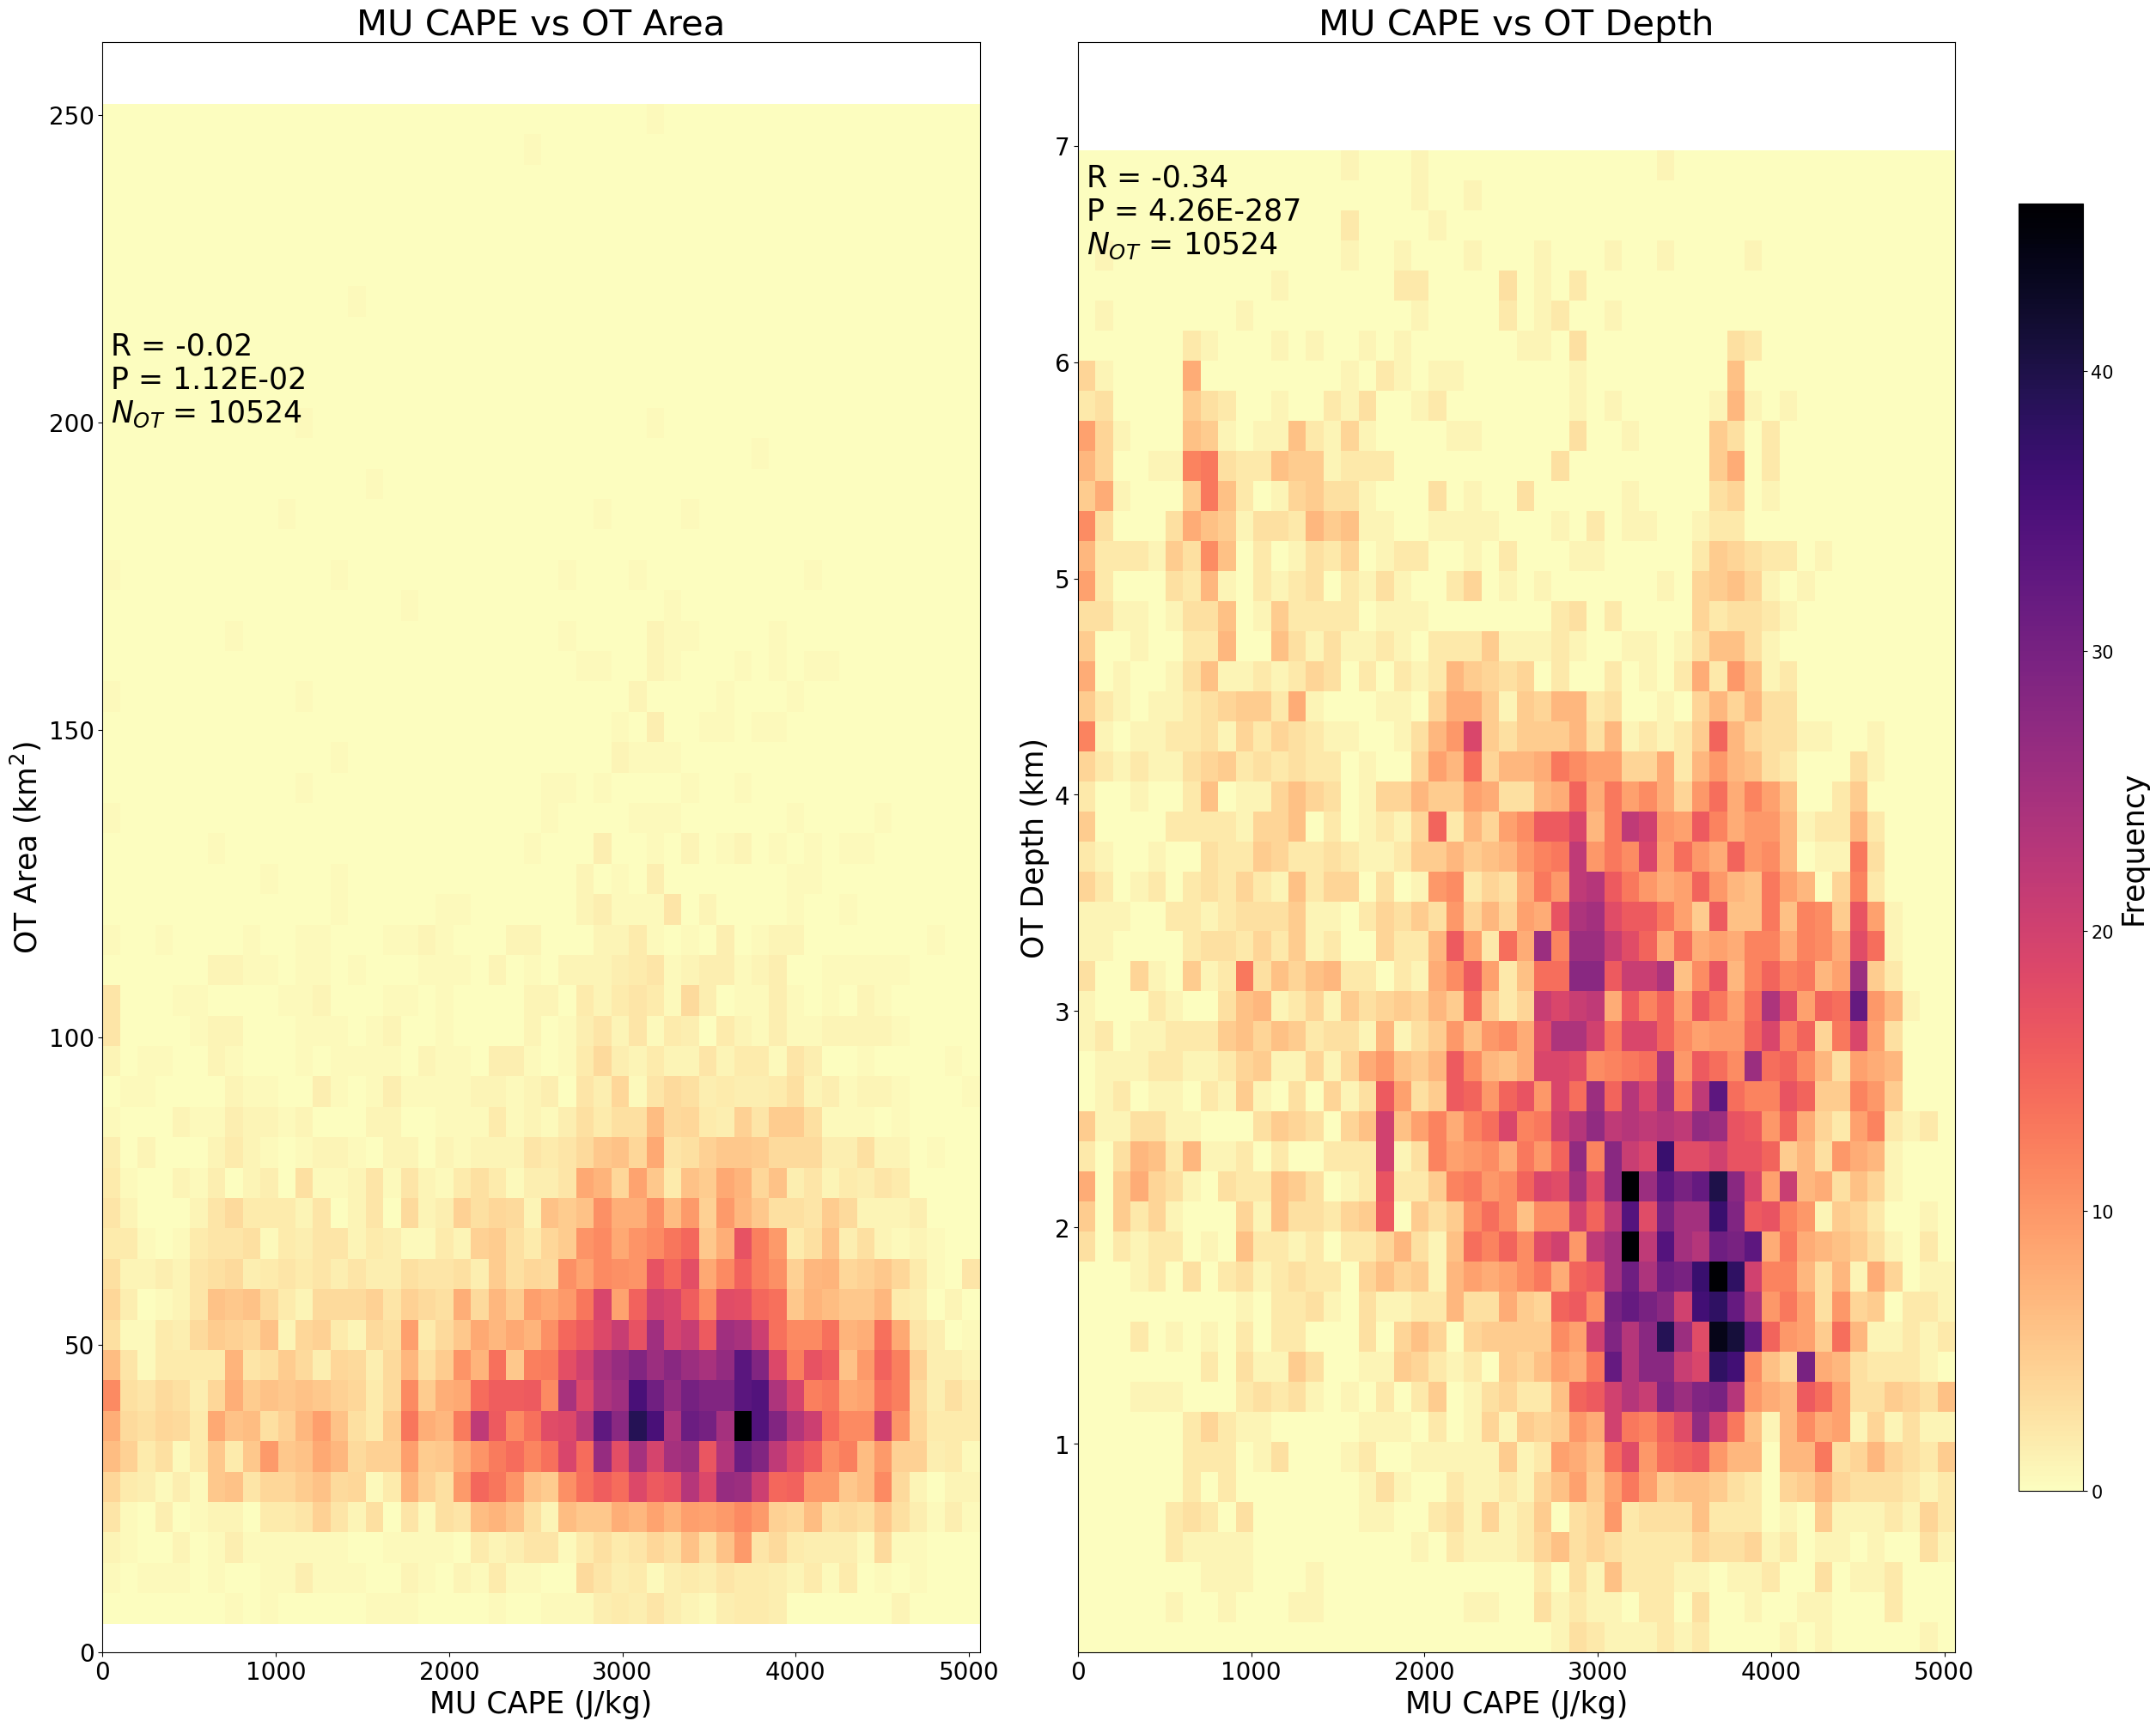

In [13]:
#Plot OTA and OTD as a function of CAPE
fig1, axes = plt.subplots(1,2,figsize=(25, 20), constrained_layout=True)
samples = len(ota_25jan)

ota_r_model = scipy.stats.linregress(mucape, ota_25jan)
r_ota = ota_r_model.rvalue
p_ota = ota_r_model.pvalue
x2 = np.linspace(min(mucape), max(mucape),100)
y2 = ota_r_model.intercept + x2*ota_r_model.slope
#print([r_ota, p_ota])

c,x,y, im1 = axes[0].hist2d(mucape, ota_25jan, bins = (50,50), cmap = rev_map)
axes[0].text(50, 200, 'R = %0.2f\n'%r_ota + 'P = %0.2E\n'%p_ota + '$N_{OT}$ = %0.0f'%samples, fontsize = 25, color = 'black')
#axes[0].plot(x2, y2, '-k')
axes[0].set_title('MU CAPE vs OT Area', fontsize = 30)
axes[0].set_xlabel('MU CAPE (J/kg)', fontsize = 25)
axes[0].set_ylabel('OT Area (km$^{2}$)', fontsize = 25)
axes[0].set_ylim(0, max(ota_25jan)+10)
#axes[0].legend( loc = 'best', fontsize = 10)
axes[0].tick_params(axis='x', labelsize=20)
axes[0].tick_params(axis='y', labelsize=20)

otd_r_model = scipy.stats.linregress(mucape, otd_25jan)
r_otd = otd_r_model.rvalue
p_otd = otd_r_model.pvalue
y3 = otd_r_model.intercept + x2*otd_r_model.slope
#print([r_otd, p_otd])
c,x,y, im1 = axes[1].hist2d(mucape, otd_25jan, bins = (50,50), cmap = rev_map)
axes[1].text(50, 6.5, 'R = %0.2f\n'%r_otd + 'P = %0.2E\n'%p_otd + '$N_{OT}$ = %0.0f'%samples, fontsize = 25, color = 'black')
axes[1].set_title('MU CAPE vs OT Depth', fontsize = 30)
#axes[1].plot(x2, y3, '-k')
axes[1].set_xlabel('MU CAPE (J/kg)', fontsize = 25)
axes[1].set_ylabel('OT Depth (km)', fontsize = 25)
axes[1].set_ylim(min(otd_25jan), max(otd_25jan)+0.5)
#axes[1].legend(loc = 'best', fontsize = 20)
axes[1].tick_params(axis='x', labelsize=20)
axes[1].tick_params(axis='y', labelsize=20)
cbar = fig1.colorbar(im1, ax=axes[1], shrink=0.8)
cbar.set_label('Frequency', fontsize = 25)
cbar.ax.tick_params(labelsize = 15)

Text(0.5, 0.98, 'Median Statistics')

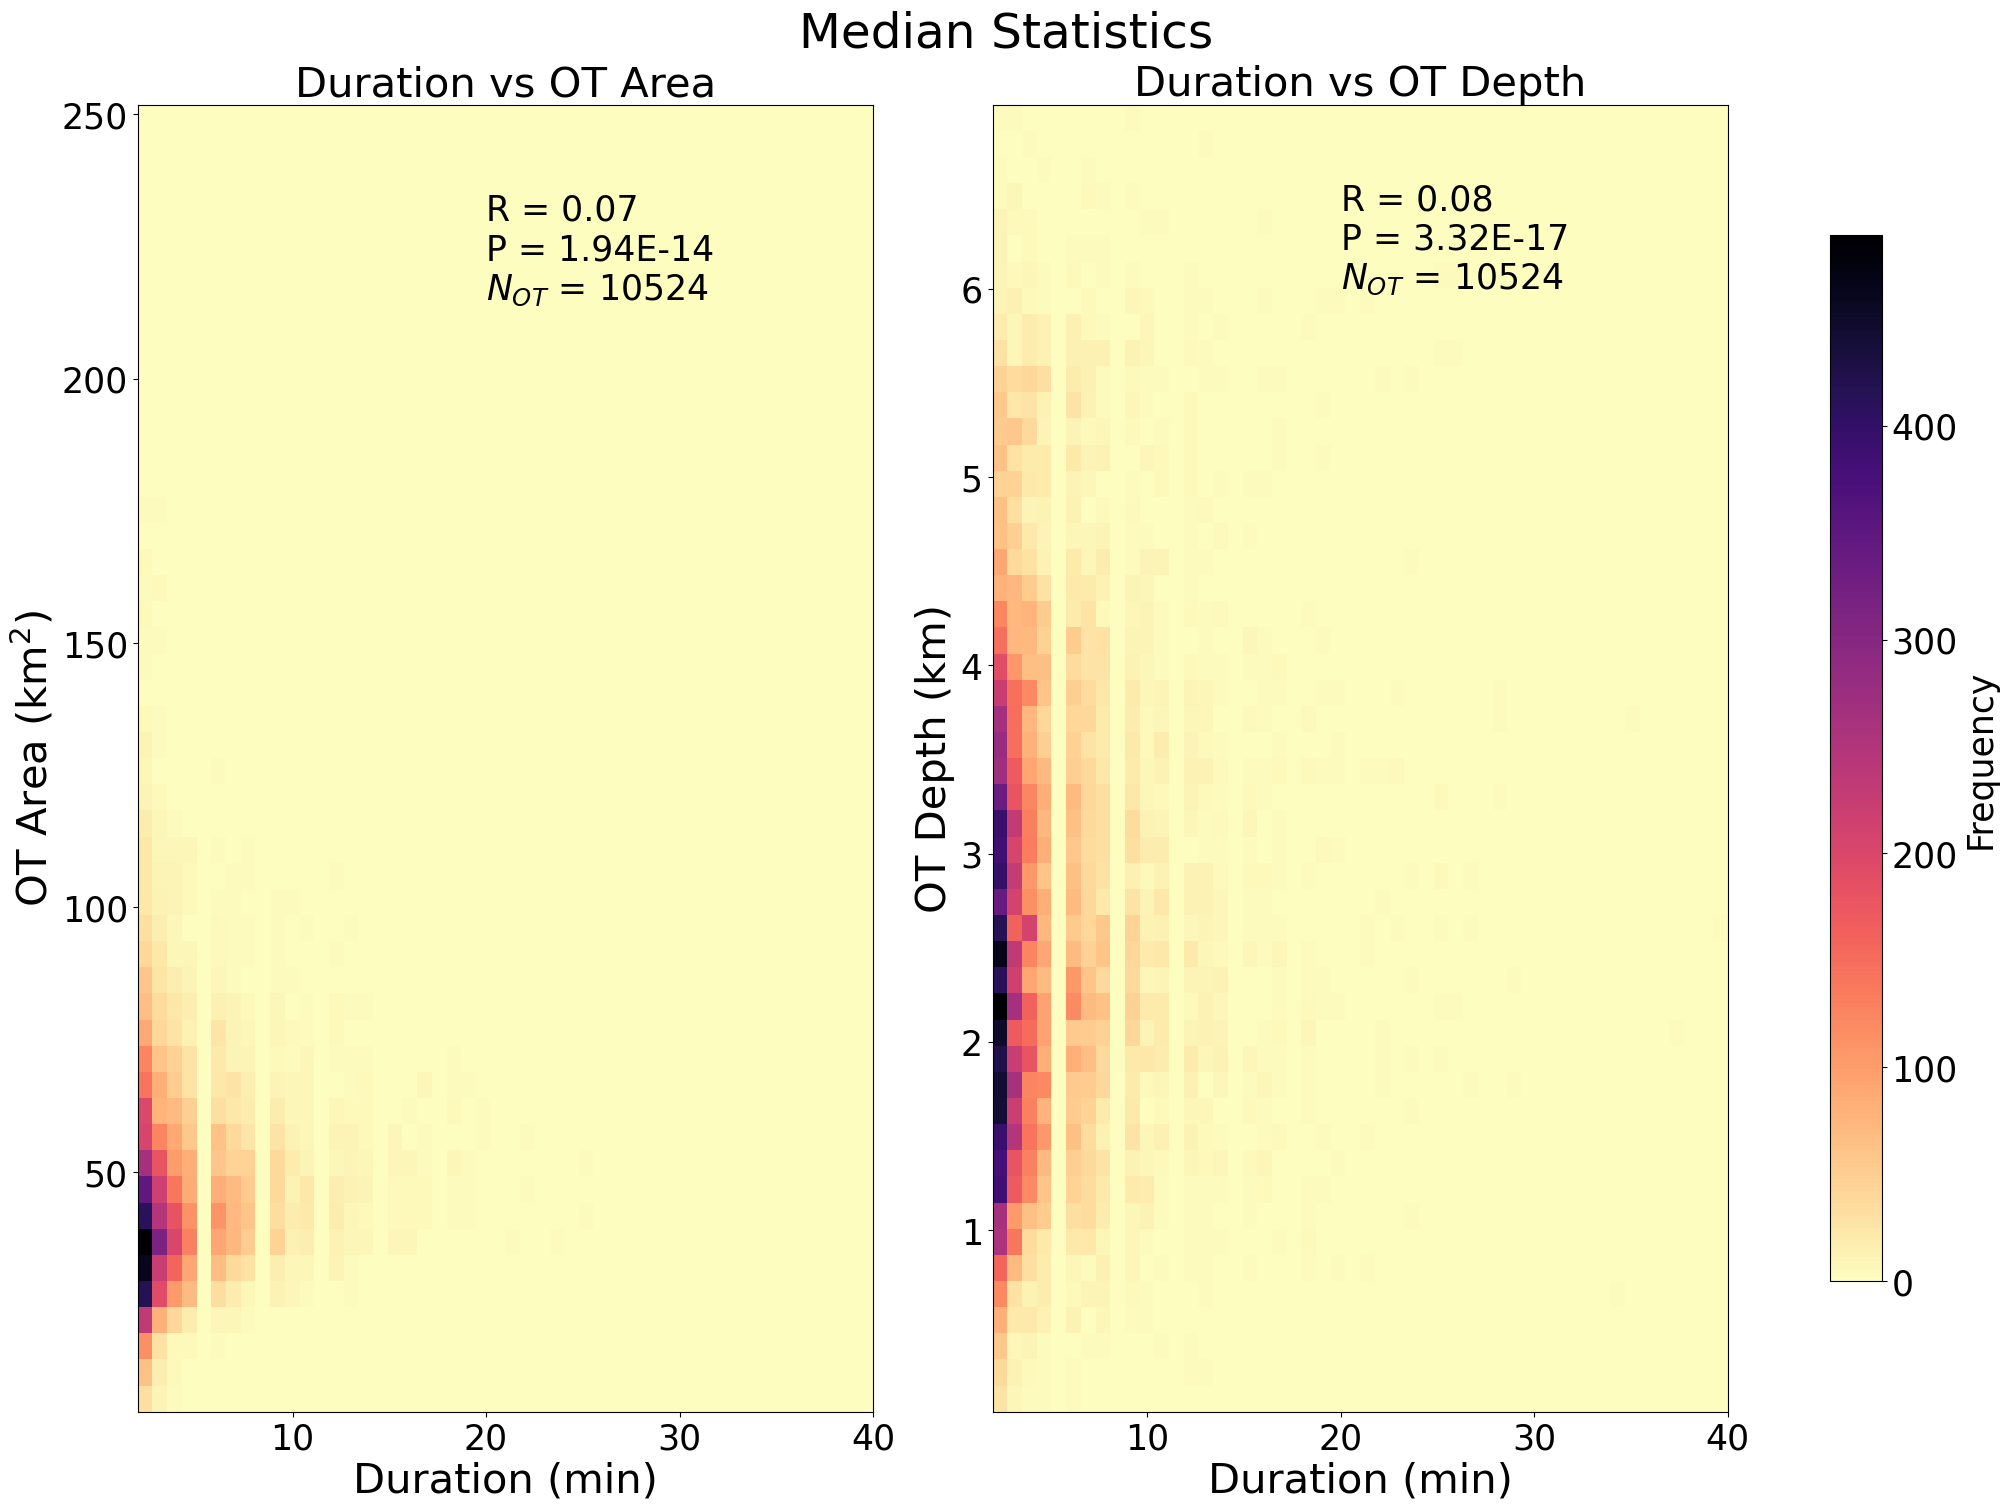

In [14]:
fig1, axes = plt.subplots(1,2,figsize=(20,15), constrained_layout=True)
samples = len(ota_25jan)
ota_r_model = scipy.stats.linregress(duration, ota_25jan)
r_ota = ota_r_model.rvalue
p_ota = ota_r_model.pvalue

c,x,y, im1 = axes[0].hist2d(duration, ota_25jan, bins = (50,50), cmap = rev_map)
axes[0].text(20, 215, 'R = %0.2f\n'%r_ota + 'P = %0.2E\n'%p_ota + '$N_{OT}$ = %0.0f'%samples, fontsize = 25, color = 'black')
#axes[0,0].plot(x5, y5, '-k')
axes[0].set_title('Duration vs OT Area', fontsize = 30)
axes[0].set_xlabel('Duration (min)', fontsize = 30)
axes[0].set_ylabel('OT Area (km$^{2}$)', fontsize = 30)
#axes[0,0].legend( loc = 'best', fontsize = 10)
axes[0].tick_params(axis='x', labelsize=25)
axes[0].tick_params(axis='y', labelsize=25)
otd_r_model2 = scipy.stats.linregress(duration, otd_25jan)
r_otd2 = otd_r_model2.rvalue
p_otd2 = otd_r_model2.pvalue
#print([r_otd, p_otd])
axes[1].hist2d(duration, otd_25jan, bins=(50,50), cmap = rev_map)
axes[1].text(20, 6, 'R = %0.2f\n'%r_otd2 + 'P = %0.2E\n'%p_otd2 + '$N_{OT}$ = %0.0f'%samples, fontsize = 25, color = 'black')
axes[1].set_title('Duration vs OT Depth', fontsize = 30)
#axes[0,1].plot(x5, y6, '-k')
axes[1].set_xlabel('Duration (min)', fontsize = 30)
axes[1].set_ylabel('OT Depth (km)', fontsize = 30)
#axes[0,1].legend(loc = 'best', fontsize = 10)
axes[1].tick_params(axis='x', labelsize=25)
axes[1].tick_params(axis='y', labelsize=25)
cbar = fig1.colorbar(im1, ax=axes[:], shrink=0.8)
cbar.set_label('Frequency', fontsize = 25)
cbar.ax.tick_params(labelsize = 25)
plt.suptitle('Median Statistics', fontsize = 35)

In [15]:
mean_area = grouped_ots.mean("area_polygon")
mean_depth = grouped_ots.mean("ot_depth")

In [16]:
mean_area['hour'] = mean_area['hour'].astype(int)
mean_depth['hour'] = mean_depth['hour'].astype(int)

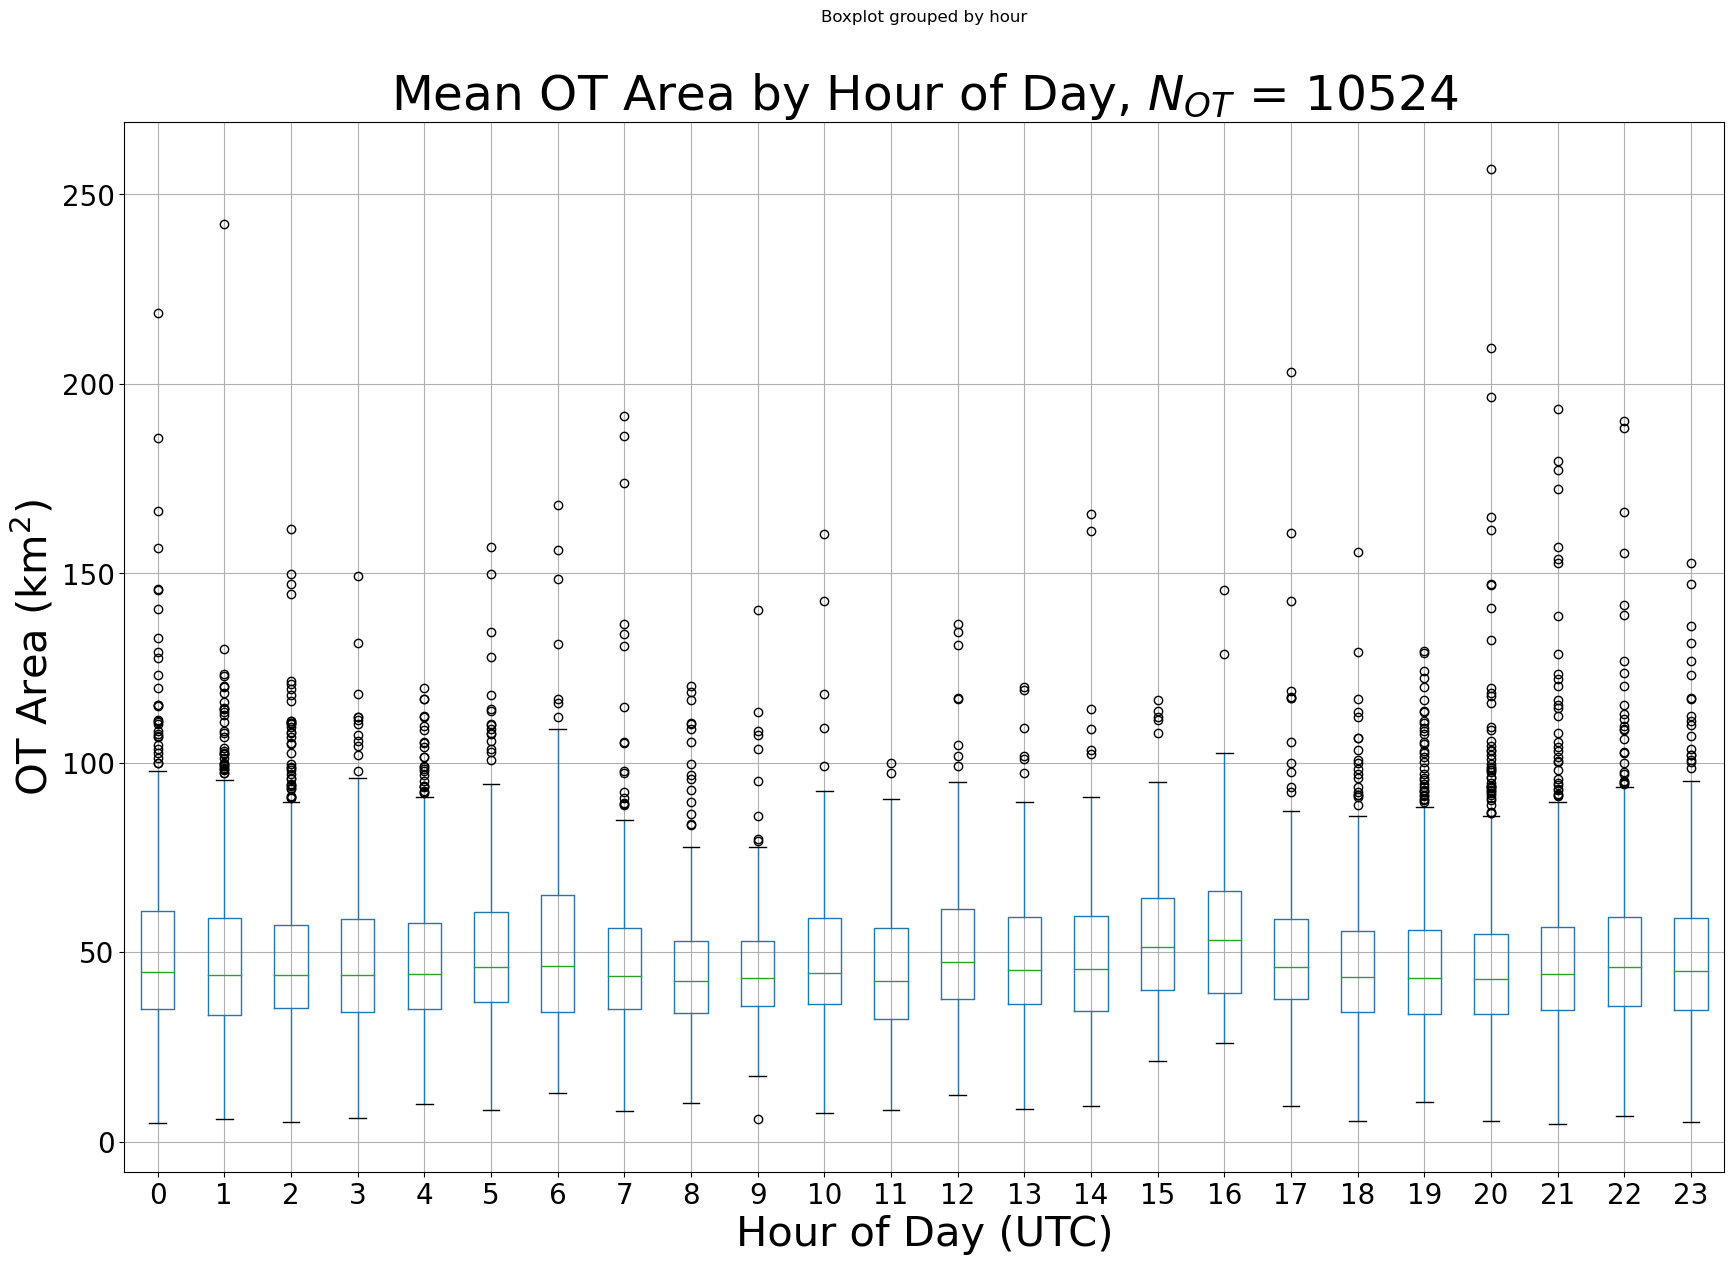

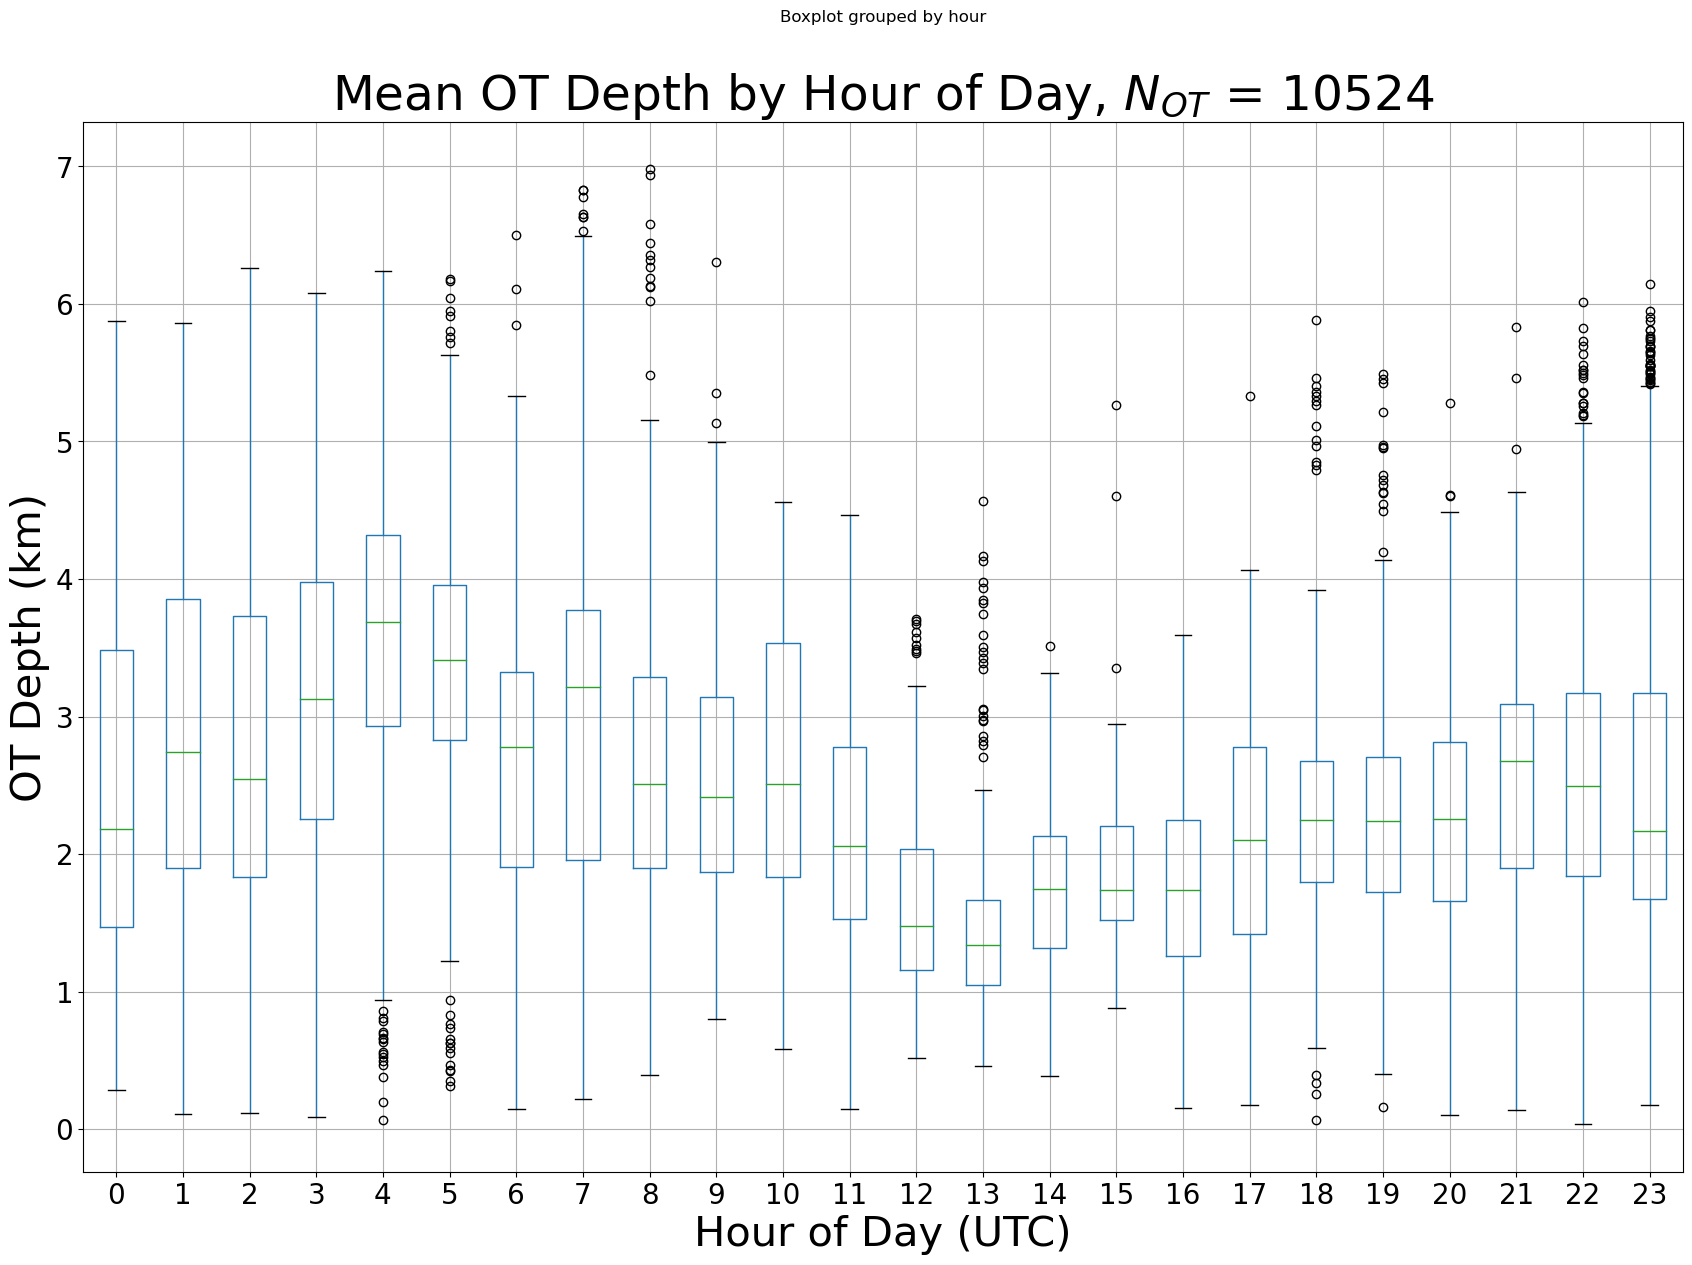

In [17]:
bpa = mean_area.boxplot(column='area_polygon', by='hour', figsize = (20, 14))
bpa.set_ylabel('OT Area (km$^{2}$)', fontsize = 30)
bpa.set_xlabel('Hour of Day (UTC)', fontsize = 30)
bpa.tick_params(axis='x', labelsize=20)
bpa.tick_params(axis='y', labelsize = 20)
bpa.set_title('Mean OT Area by Hour of Day, $N_{OT}$ = %0.0f'%samples, fontsize = 35)
bpd = mean_depth.boxplot(column='ot_depth', by = 'hour', figsize = (20, 14))
bpd.set_ylabel('OT Depth (km)', fontsize = 30)
bpd.set_xlabel('Hour of Day (UTC)', fontsize = 30)
bpd.set_title('Mean OT Depth by Hour of Day, $N_{OT}$ = %0.0f'%samples, fontsize = 35)
bpd.tick_params(axis='x', labelsize=20)
bpd.tick_params(axis='y', labelsize = 20)



In [18]:
#Count the number of OTs per each hour
counts_per_hour = gpd_jan25['hours'].value_counts()
hrs = np.arange(0, 24, 1)
cph = [3880, 5338, 4682, 2860, 3467, 2292, 1646, 1881, 1332, 1180, 1017, 536, 1320, 1050, 837, 403, 606, 1229, 2294, 2980, 3360, 3455, 3392, 3585]
print(sum(cph))

54622


(array([   0., 1000., 2000., 3000., 4000., 5000., 6000.]),
 [Text(0, 0.0, '0'),
  Text(0, 1000.0, '1000'),
  Text(0, 2000.0, '2000'),
  Text(0, 3000.0, '3000'),
  Text(0, 4000.0, '4000'),
  Text(0, 5000.0, '5000'),
  Text(0, 6000.0, '6000')])

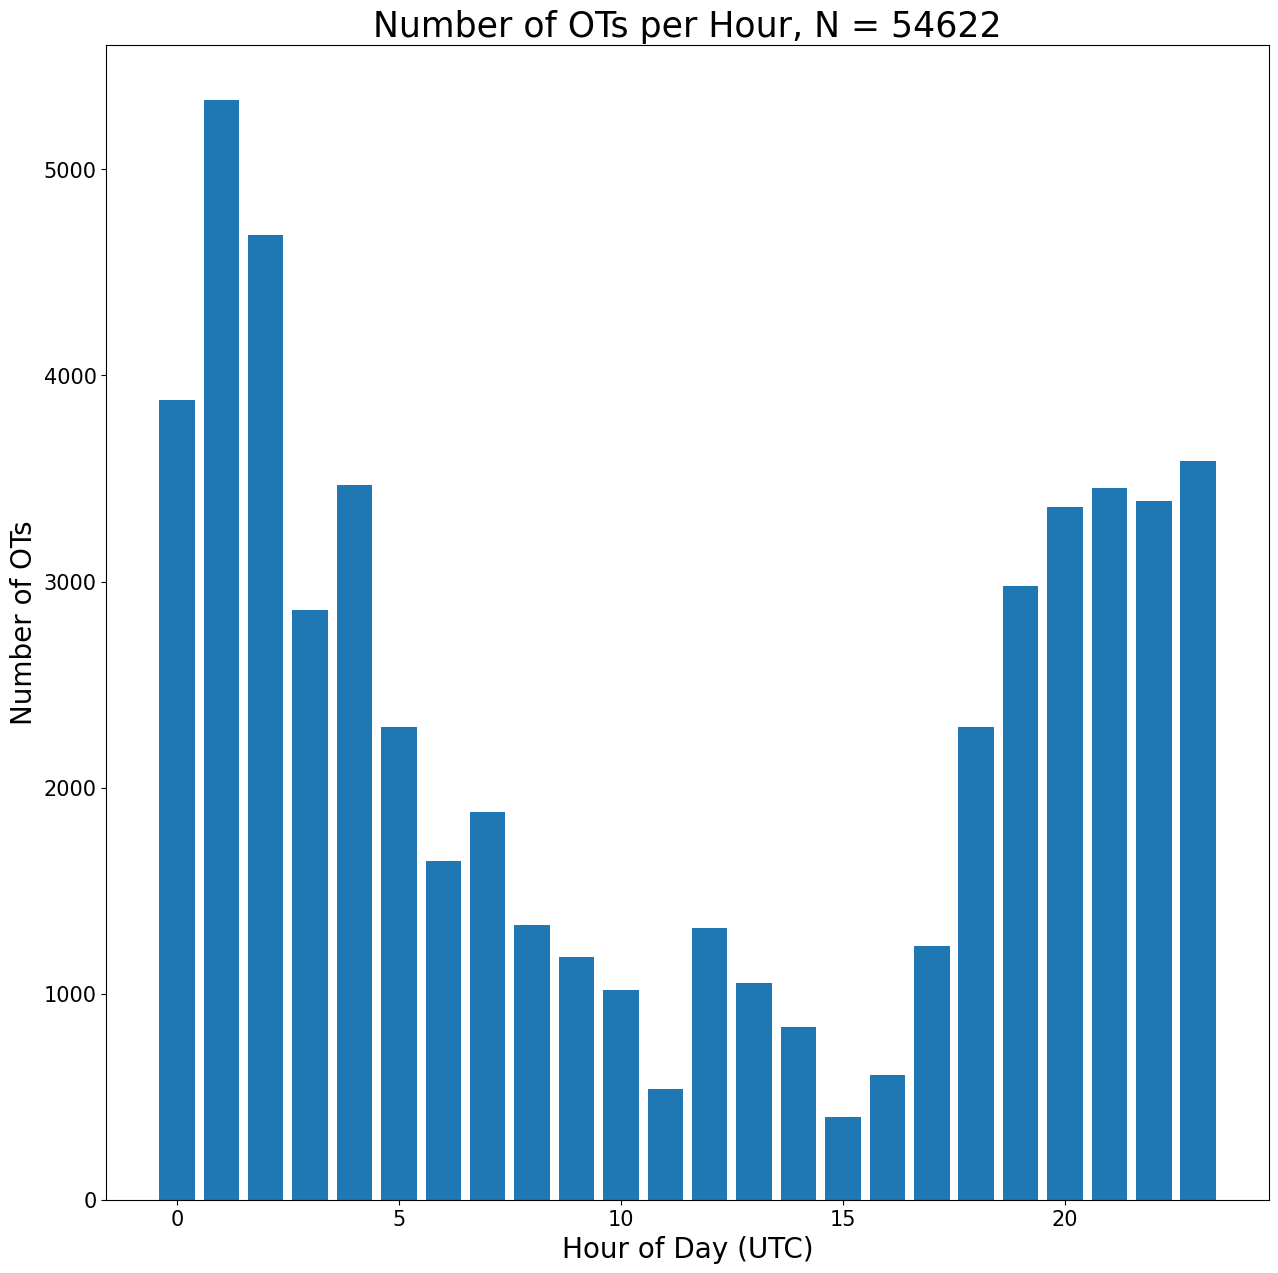

In [19]:
#Create a bar plot of the number of OTs per hour 
fig = plt.figure(figsize = (15,15))
plt.bar(hrs, cph)
plt.title('Number of OTs per Hour, N = 54622', fontsize = 25)
plt.xlabel('Hour of Day (UTC)', fontsize = 20)
plt.ylabel('Number of OTs', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)


In [20]:
#Plot the tracks over the satellite data
#Load the satellite data
import glob
datestr='20181110'
ihour='20'
ihour2 = '19'
ihour3 = '21'
#files = sorted(glob.glob(f'/data/accp/a/snesbitt/arm/goesV2/*{datestr}.{ihour}????.cdf'))
files = sorted(glob.glob(f'/data/accp/a/snesbitt/arm/goesV2/*{datestr}.*.cdf'))


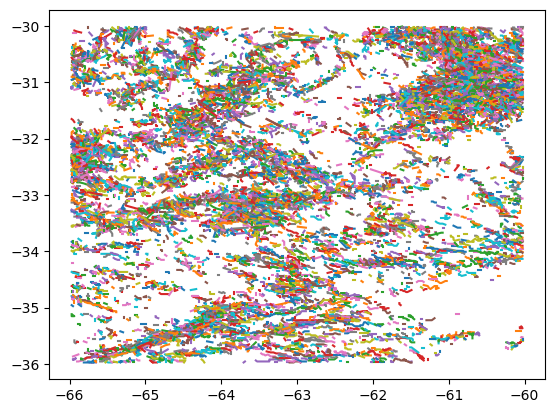

In [21]:
#Plot all the tracks over the topography

for name, group in grouped_ots:
    tracks = grouped_ots.get_group(name)
    plt.plot(tracks.lon, tracks.lat)

Text(0.5, 1.0, 'All OT Tracks')

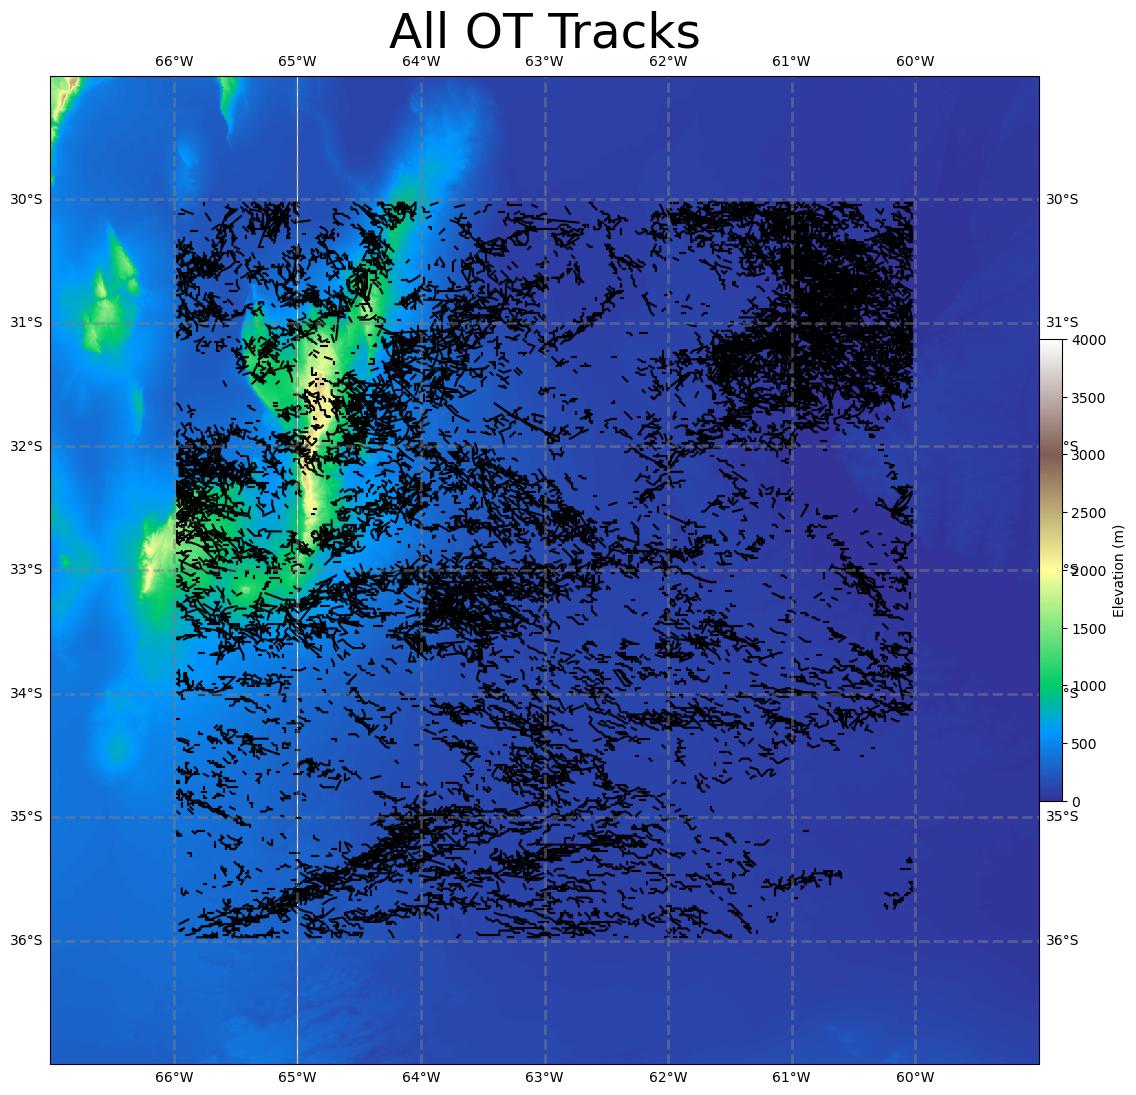

In [22]:
llcrnr=[-37, -67]
urcrnr=[-29, -59]

# Set extent of maps created in the following cells:
axis_extent=[llcrnr[1],urcrnr[1],llcrnr[0],urcrnr[0]]    

# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(15,15),subplot_kw={'projection': ccrs.PlateCarree()})

ax_map.coastlines()

ax_map.set_extent(axis_extent)

for ds in ds_list:
#    cm = ax.contourf(ds.x.values[::5], ds.y.values[::5], ds.values[::5,::5], levs, cmap='terrain', transform=ccrs.PlateCarree())
    cm = ax_map.imshow(ds.values, extent =[ds.x.min(),ds.x.max(),ds.y.min(),ds.y.max()], transform=ccrs.PlateCarree(), vmin=0, vmax=4000, cmap='terrain')

gl = ax_map.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
plt.colorbar(cm,label='Elevation (m)',shrink=0.4, pad=0.0)
for name, group in grouped_ots:
    tracks = grouped_ots.get_group(name)
    plt.plot(tracks.lon, tracks.lat, color = 'k')
plt.title('All OT Tracks', fontsize = 35)

In [23]:
test_file = xr.open_dataset(files[122])

test_file

<xarray.Dataset>
Dimensions:                                         (time: 1, nlines: 728,
                                                     npixels: 672)
Coordinates:
  * time                                            (time) datetime64[ns] 201...
    latitude                                        (nlines) float32 ...
    longitude                                       (npixels) float32 ...
Dimensions without coordinates: nlines, npixels
Data variables: (12/20)
    scan_time                                       (nlines) datetime64[ns] ...
    ir_brightness_temperature                       (time, nlines, npixels) float32 ...
    ot_id_number                                    (time, nlines, npixels) float32 ...
    ot_probability                                  (time, nlines, npixels) float32 ...
    hiwc_probability                                (time, nlines, npixels) float32 ...
    distance_to_overshooting_top                    (time, nlines, npixels) float32 ...
    ...                                              ...
    cloud_top_pressure                              (time, nlines, npixels) float32 ...
    cloud_top_potential_temperature                 (time, nlines, npixels) float32 ...
    ir_anvil_detection                              (time, nlines, npixels) float32 ...
    visible_reflectance                             (time, nlines, npixels) float32 ...
    ot_rating_visible                               (time, nlines, npixels) float32 ...
    visible_anvil_detection                         (time, nlines, npixels) float32 ...
Attributes: (12/22)
    title:                        Geostationary Visible and Infrared Imager D...
    summary:                      This file contains products designed to ide...
    reference1:                   Khlopenkov, K. V., Bedka, K. M., Cooney, J....
    reference2:                   Yost, C. R., Bedka, K. M., Minnis, P., Nguy...
    creator_name:                 Kristopher Bedka and Konstantin Khlopenkov
    creator_email:                kristopher.m.bedka@nasa.gov, konstantin.khl...
    ...                           ...
    geospatial_lat_max:           -26.01
    geospatial_lon_min:           -69.99
    geospatial_lon_max:           -58.01
    time_coverage_start:          2018-11-10T17:02:57Z
    time_coverage_end:            2018-11-10T17:03:27Z
    numerical_model_data_source:  MERRA-2

In [24]:
sat_time = test_file.time.values[0]

sat_time

numpy.datetime64('2018-11-10T17:02:55.000000512')

In [25]:
t = pd.to_datetime(str(sat_time))

d = t.strftime('%Y-%m-%d %H:%M:%S')

In [26]:
date_df = gpd_jan25[gpd_jan25.time_conv == d]

In [27]:
d

'2018-11-10 17:02:55'

In [28]:
date_df

Unnamed: 0.1  Unnamed: 0                           time        lat  \
662         20543         313  2018-11-10 17:02:55.000000512 -33.151787   
663         20544         314  2018-11-10 17:02:55.000000512 -34.044643   
664         20545         315  2018-11-10 17:02:55.000000512 -34.133930   
665         20546         316  2018-11-10 17:02:55.000000512 -34.151787   
666         20547         317  2018-11-10 17:02:55.000000512 -34.151787   
667         20548         318  2018-11-10 17:02:55.000000512 -34.276787   
668         20549         319  2018-11-10 17:02:55.000000512 -34.258926   

           lon   lat_corr   lon_corr  otid      mintb  tropopause_height  ...  \
662 -64.223220 -33.030790 -64.265220   6.0  200.90000          15.684001  ...   
663 -60.026783 -33.928642 -60.080784  20.0  204.51000          14.761001  ...   
664 -61.669643 -34.014930 -61.719643  26.0  203.01000          14.852000  ...   
665 -62.133930 -34.025787 -62.184930  27.0  199.62999          14.907001  ...   
666 -62.116070 -34.023790 -62.168068  34.0  198.05000          14.909000  ...   
667 -62.044640 -34.150787 -62.095640  40.0  199.64000          14.805000  ...   
668 -61.473213 -34.136925 -61.524210  42.0  201.39000          14.730000  ...   

     hour  particle   cell  count  Count_Column            time_conv  \
662    17       235  236.0    1.0           4.0  2018-11-10 17:02:55   
663    17       241    NaN    NaN           NaN  2018-11-10 17:02:55   
664    17       237  238.0    1.0           2.0  2018-11-10 17:02:55   
665    17       238  239.0    1.0           2.0  2018-11-10 17:02:55   
666    17       239  240.0    1.0          12.0  2018-11-10 17:02:55   
667    17       242  243.0    1.0           4.0  2018-11-10 17:02:55   
668    17       231  232.0    1.0           7.0  2018-11-10 17:02:55   

     ot_depth duration  hours month  
662  1.622629      4.0     17    11  
663  1.988965      NaN     17    11  
664  2.486038      2.0     17    11  
665  3.406200      2.0     17    11  
666  3.649439     12.0     17    11  
667  3.317349      4.0     17    11  
668  2.701604      7.0     17    11  

[7 rows x 64 columns]

In [29]:
grouped_test = date_df.groupby('cell')

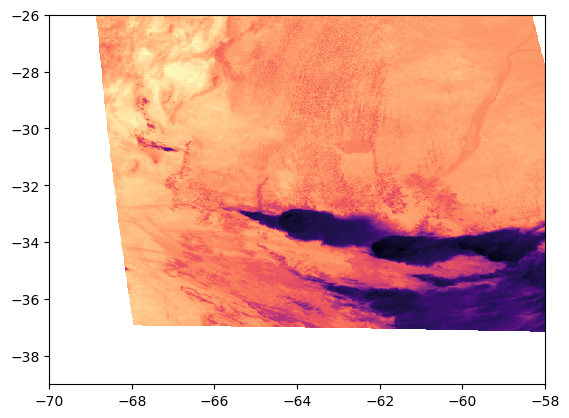

In [ ]:
ir_temps = test_file.ir_brightness_temperature[0].values
lons = test_file.longitude.values
lats = test_file.latitude.values

plt.pcolormesh(lons, lats, ir_temps, cmap = 'magma')

In [49]:
for file in files[100:110]:
    test_file = xr.open_dataset(file)
    sat_time = test_file.time.values[0]
    t = pd.to_datetime(str(sat_time))
    d = t.strftime('%Y-%m-%d %H:%M:%S')


    date_df = gpd_jan25[gpd_jan25.time_conv == d] 
    grouped_test = date_df.groupby('cell') 
    ir_temps = test_file.ir_brightness_temperature[0].values
    lons = test_file.longitude.values
    lats = test_file.latitude.values

    plt.figure(figsize=(15,15))
    plt.pcolormesh(lons, lats, ir_temps, cmap = 'magma')
    for name, group in grouped_test:
        tracks = grouped_test.get_group(name)
        plt.plot(tracks.lon, tracks.lat, 'o-')
        plt.title('Brightness Temperature and Tracks at %')
    
    
    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

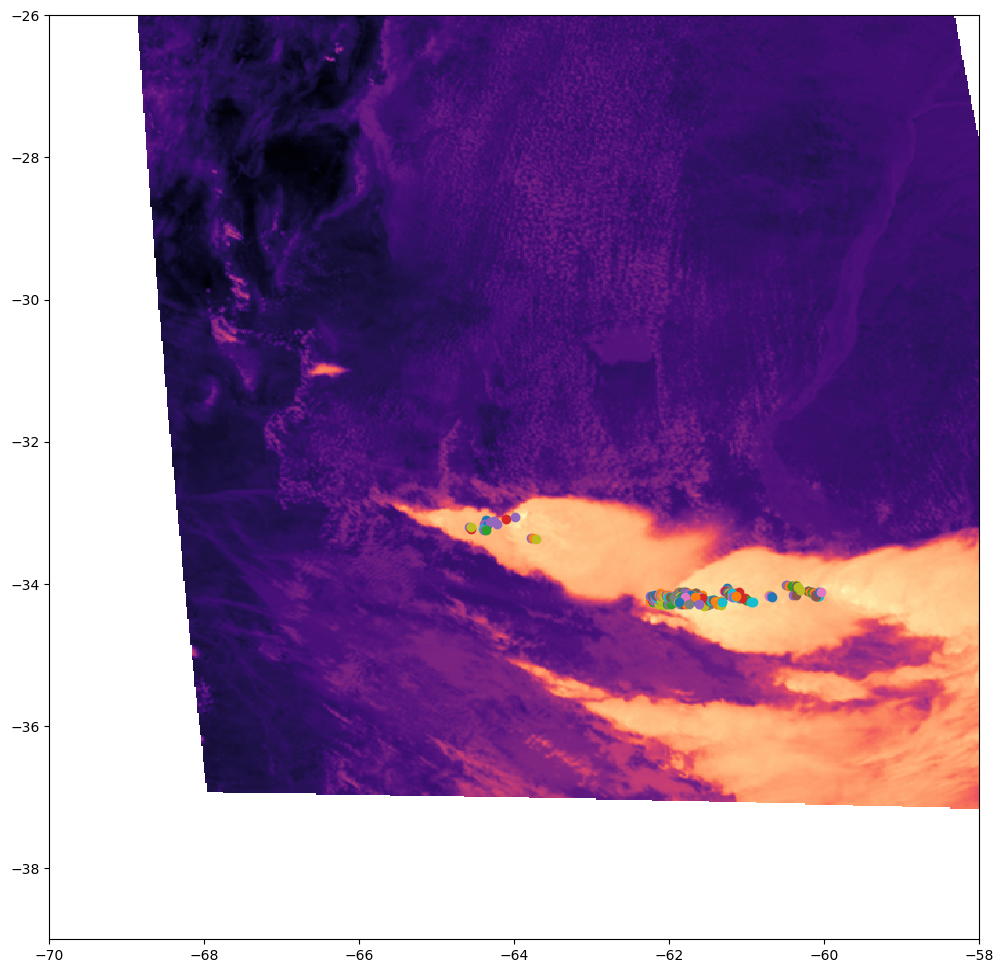

In [30]:
import matplotlib.animation as anim

fig, ax = plt.subplots(figsize= (12,12))


for file in files[100:150]:
    test_file = xr.open_dataset(file)
    sat_time = test_file.time.values[0]
    t = pd.to_datetime(str(sat_time))
    d = t.strftime('%Y-%m-%d %H:%M:%S')
    ir_temps = test_file.ir_brightness_temperature[0].values
    lons = test_file.longitude.values
    lats = test_file.latitude.values

    date_df = gpd_jan25[gpd_jan25.time_conv == d] 
    grouped_test = date_df.groupby('cell') 

    xdata, ydata = [], []
    lng, ltt, irs = [], [], []
    #ln2, = plt.pcolormesh([], [], [], cmap = 'rev_map')
    ln, = plt.plot([], [], '-o')

   
    def update(i):
        """
        updates the plot for each animation frame
        """

        for name, group in grouped_test:
            tracks = grouped_test.get_group(name)
            ln.set_data(tracks.lon, tracks.lat)
        return ln,

    
    plt.pcolormesh(lons, lats, ir_temps, cmap = rev_map)
    for name, group in grouped_test:
            tracks = grouped_test.get_group(name)
            newsegm,  = plt.plot(tracks.lon, tracks.lat, 'o-')
  

ani = anim.FuncAnimation(fig, update, frames = len(gpd_jan25), interval = 100, blit=True)
plt.show()         






In [33]:
f = '/data/keeling/a/melinda3/accp/tracking_ots/test_tracking1.gif'

writergif = anim.PillowWriter(fps=30)
ani.save(f, writer=writergif)

KeyboardInterrupt: 